In [1]:
import os
import numpy as np
from Brats2020_Segmentation_Data_Generatorv2 import imageLoader
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random
from keras import backend as K
from matplotlib import pyplot as plt
import random
from tqdm import tqdm


In [2]:
def conv_block(inputs, filters, kernel_size=3):
    x = inputs
    for i in range(2):
        x = tf.keras.layers.Conv3D(filters, kernel_size, kernel_initializer="he_normal",
                                   padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)  # Apply BatchNorm
        x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(inputs, filters=16):
    f = conv_block(inputs, filters=filters)  # output for the concat
    p = tf.keras.layers.MaxPooling3D((2, 2, 2))(f)
    p = tf.keras.layers.Dropout(0.2)(p)
    return f, p


def encoder(inputs):
    filters = 16
    f1, p1 = encoder_block(inputs, filters)
    f2, p2 = encoder_block(p1, filters * 2)
    f3, p3 = encoder_block(p2, filters * 4)
    f4, p4 = encoder_block(p3, filters * 8)
    return p4, (f1, f2, f3, f4)


def bottleneck(inputs):
    bottle_neck = conv_block(inputs, 256)
    return bottle_neck


def decoder_block(inputs, conv_out, filters=128, kernel_size=3, strides=(2, 2, 2)):
    u = tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides, padding="same")(inputs)
    cat = tf.keras.layers.concatenate([u, conv_out])
    cat = tf.keras.layers.Dropout(0.2)(cat)
    cat = conv_block(cat, filters, kernel_size)
    return cat


def decoder(inputs, convs, out_channels, filters=128):
    f1, f2, f3, f4 = convs

    c6 = decoder_block(inputs, f4, filters)
    c7 = decoder_block(c6, f3, filters // 2)
    c8 = decoder_block(c7, f2, filters // 4)
    c9 = decoder_block(c8, f1, filters // 8)

    outputs = tf.keras.layers.Conv3D(out_channels, 1, activation="softmax")(c9)
    return outputs


In [3]:
OUTPUT_CHANNELS=4
def unet():
    
    inputs= tf.keras.layers.Input(shape=(128, 128, 128, 4))
    
    encoder_output, convs = encoder(inputs)
    bottle_neck= bottleneck(encoder_output)
    outputs= decoder(bottle_neck, convs, OUTPUT_CHANNELS)
    model= tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model= unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 4)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1744        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 12  64         ['conv3d[0][0]']                 
 alization)                     8, 16)                                                        

                                                                                                  
 activation_6 (Activation)      (None, 16, 16, 16,   0           ['batch_normalization_6[0][0]']  
                                128)                                                              
                                                                                                  
 conv3d_7 (Conv3D)              (None, 16, 16, 16,   442496      ['activation_6[0][0]']           
                                128)                                                              
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 16, 16, 16,   512        ['conv3d_7[0][0]']               
 rmalization)                   128)                                                              
                                                                                                  
 activatio

                                64)                                                               
                                                                                                  
 batch_normalization_13 (BatchN  (None, 32, 32, 32,   256        ['conv3d_13[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_13 (Activation)     (None, 32, 32, 32,   0           ['batch_normalization_13[0][0]'] 
                                64)                                                               
                                                                                                  
 conv3d_transpose_2 (Conv3DTran  (None, 64, 64, 64,   55328      ['activation_13[0][0]']          
 spose)                         32)                                                               
          

In [4]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 4)
(None, 128, 128, 128, 4)


In [5]:
train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [6]:
batch_size = 1

train_dataset = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_dataset = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [7]:
input_images, target_images=train_dataset.__next__()

In [8]:
# Print shape information
print("Shape of input images:", input_images.shape)
print("Shape of target images:", target_images.shape)

Shape of input images: (1, 128, 128, 128, 4)
Shape of target images: (1, 128, 128, 128, 4)


In [9]:
def dice_loss(y_true, y_pred):
    smooth = 1e-5  # Smoothing factor to avoid division by zero
    
    # Flatten the true and predicted tensors
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    
    
    # Compute the intersection and sum of true and predicted tensors
    intersection = (tf.reduce_sum(y_true_flat * y_pred_flat, axis=0))
    
    
    sum_true = tf.reduce_sum(y_true_flat, axis=0)
    sum_pred = tf.reduce_sum(y_pred_flat, axis=0)
    union=(sum_true+sum_pred)
    
    # Compute the dice coefficient for each class
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = 1.0 - dice_coefficient
    return dice_loss
    

In [10]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-5  # Smoothing factor to avoid division by zero
    
    # Flatten the true and predicted tensors
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    
    
    # Compute the intersection and sum of true and predicted tensors
    intersection = (tf.reduce_sum(y_true_flat * y_pred_flat, axis=0))
    
    
    sum_true = tf.reduce_sum(y_true_flat, axis=0)
    sum_pred = tf.reduce_sum(y_pred_flat, axis=0)
    union=(sum_true+sum_pred)
    
    # Compute the dice coefficient for each class
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    
    return dice_coefficient

In [11]:
metrics = ['accuracy', dice_coeff]

In [12]:
LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [14]:
model.compile(optimizer = "adam", loss=dice_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 4)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1744        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 12  64         ['conv3d[0][0]']                 
 alization)                     8, 16)                                                        

                                                                                                  
 activation_6 (Activation)      (None, 16, 16, 16,   0           ['batch_normalization_6[0][0]']  
                                128)                                                              
                                                                                                  
 conv3d_7 (Conv3D)              (None, 16, 16, 16,   442496      ['activation_6[0][0]']           
                                128)                                                              
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 16, 16, 16,   512        ['conv3d_7[0][0]']               
 rmalization)                   128)                                                              
                                                                                                  
 activatio

                                64)                                                               
                                                                                                  
 batch_normalization_13 (BatchN  (None, 32, 32, 32,   256        ['conv3d_13[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_13 (Activation)     (None, 32, 32, 32,   0           ['batch_normalization_13[0][0]'] 
                                64)                                                               
                                                                                                  
 conv3d_transpose_2 (Conv3DTran  (None, 64, 64, 64,   55328      ['activation_13[0][0]']          
 spose)                         32)                                                               
          

In [15]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [16]:
history=model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/100
275/275 [==============================] - 238s 808ms/step - loss: 0.1722 - accuracy: 0.9441 - dice_coeff: 0.8278 - val_loss: 0.1265 - val_accuracy: 0.9229 - val_dice_coeff: 0.8735
Epoch 2/100
275/275 [==============================] - 223s 812ms/step - loss: 0.0454 - accuracy: 0.9659 - dice_coeff: 0.9546 - val_loss: 0.0758 - val_accuracy: 0.9316 - val_dice_coeff: 0.9242
Epoch 3/100
275/275 [==============================] - 224s 814ms/step - loss: 0.0362 - accuracy: 0.9678 - dice_coeff: 0.9638 - val_loss: 0.0488 - val_accuracy: 0.9545 - val_dice_coeff: 0.9512
Epoch 4/100
275/275 [==============================] - 226s 821ms/step - loss: 0.0326 - accuracy: 0.9695 - dice_coeff: 0.9674 - val_loss: 0.0601 - val_accuracy: 0.9416 - val_dice_coeff: 0.9399
Epoch 5/100
275/275 [==============================] - 226s 821ms/step - loss: 0.0311 - accuracy: 0.9703 - dice_coeff: 0.9689 - val_loss: 0.0385 - val_accuracy: 0.9626 - val_dice_coeff: 0.9615
Epoch 6/100
275/275 [==============

275/275 [==============================] - 225s 818ms/step - loss: 0.0211 - accuracy: 0.9789 - dice_coeff: 0.9789 - val_loss: 0.0566 - val_accuracy: 0.9435 - val_dice_coeff: 0.9434
Epoch 44/100
275/275 [==============================] - 225s 818ms/step - loss: 0.0215 - accuracy: 0.9786 - dice_coeff: 0.9785 - val_loss: 0.0366 - val_accuracy: 0.9634 - val_dice_coeff: 0.9634
Epoch 45/100
275/275 [==============================] - 224s 814ms/step - loss: 0.0210 - accuracy: 0.9790 - dice_coeff: 0.9790 - val_loss: 0.0382 - val_accuracy: 0.9619 - val_dice_coeff: 0.9618
Epoch 46/100
275/275 [==============================] - 223s 813ms/step - loss: 0.0206 - accuracy: 0.9795 - dice_coeff: 0.9794 - val_loss: 0.0467 - val_accuracy: 0.9533 - val_dice_coeff: 0.9533
Epoch 47/100
275/275 [==============================] - 223s 810ms/step - loss: 0.0203 - accuracy: 0.9798 - dice_coeff: 0.9797 - val_loss: 0.0913 - val_accuracy: 0.9087 - val_dice_coeff: 0.9087
Epoch 48/100
275/275 [=====================

275/275 [==============================] - 224s 814ms/step - loss: 0.0100 - accuracy: 0.9900 - dice_coeff: 0.9900 - val_loss: 0.0525 - val_accuracy: 0.9475 - val_dice_coeff: 0.9475
Epoch 86/100
275/275 [==============================] - 224s 814ms/step - loss: 0.0101 - accuracy: 0.9899 - dice_coeff: 0.9899 - val_loss: 0.0456 - val_accuracy: 0.9544 - val_dice_coeff: 0.9544
Epoch 87/100
275/275 [==============================] - 223s 811ms/step - loss: 0.0103 - accuracy: 0.9898 - dice_coeff: 0.9897 - val_loss: 0.0548 - val_accuracy: 0.9452 - val_dice_coeff: 0.9452
Epoch 88/100
275/275 [==============================] - 222s 808ms/step - loss: 0.0101 - accuracy: 0.9900 - dice_coeff: 0.9899 - val_loss: 0.0551 - val_accuracy: 0.9449 - val_dice_coeff: 0.9449
Epoch 89/100
275/275 [==============================] - 221s 804ms/step - loss: 0.0099 - accuracy: 0.9902 - dice_coeff: 0.9901 - val_loss: 0.0547 - val_accuracy: 0.9454 - val_dice_coeff: 0.9453
Epoch 90/100
275/275 [=====================

In [17]:
# Save the trained model
from tensorflow.keras.models import save_model
# Save the trained generator model
model.save("unet_100_epochsv2")

INFO:tensorflow:Assets written to: unet_100_epochsv2\assets


INFO:tensorflow:Assets written to: unet_100_epochsv2\assets


In [18]:
import matplotlib.pyplot as plt

img_num = 132

test_img = np.load("BraTS2020_TrainingData/input_data_128/val/images/image_" + str(img_num) + ".npy")
test_mask = np.load("BraTS2020_TrainingData/input_data_128/val/masks/mask_" + str(img_num) + ".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

print("Shape of test_img:", test_img.shape)
print("Shape of test_mask:", test_mask.shape)

Shape of test_img: (128, 128, 128, 4)
Shape of test_mask: (128, 128, 128, 4)


In [19]:
test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
print("Shape of test_img:", test_prediction_argmax.shape)

1/1 [==============================] - 0s 408ms/step
Shape of test_img: (128, 128, 128)


<Figure size 1200x800 with 0 Axes>

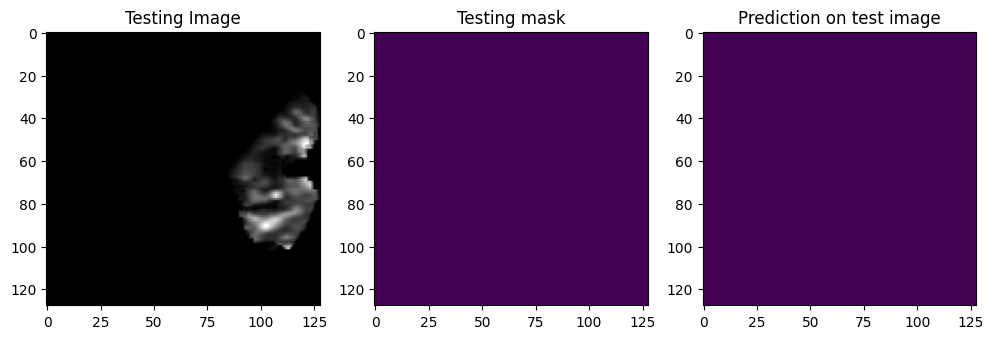

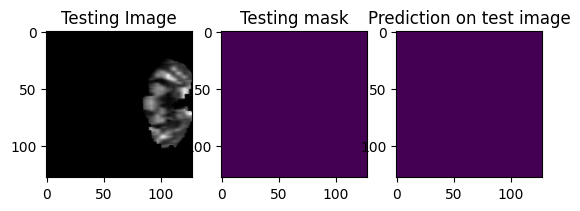

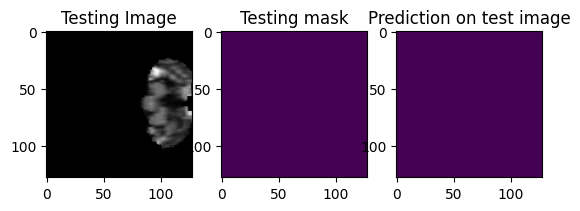

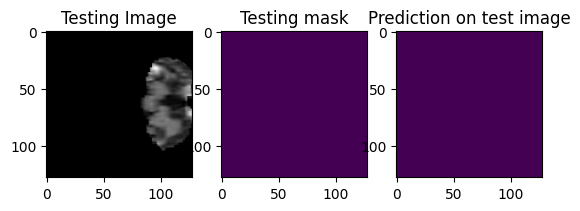

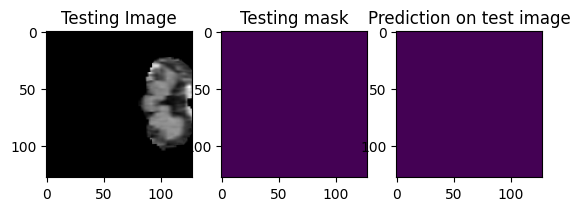

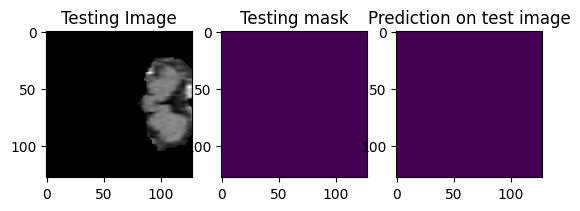

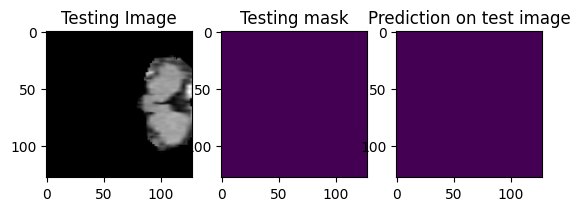

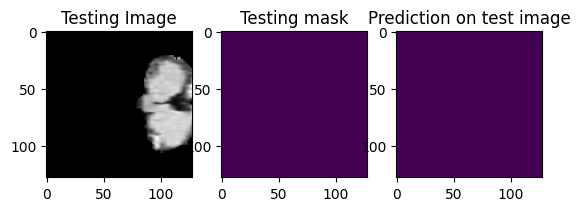

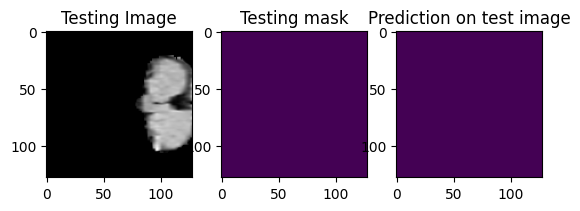

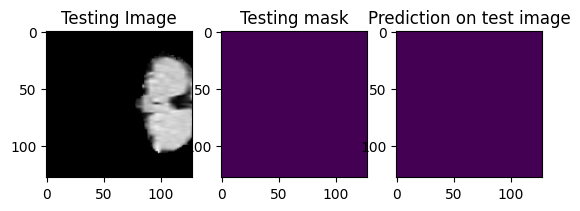

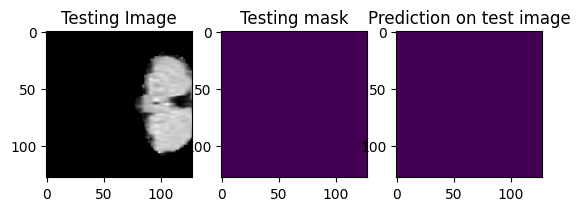

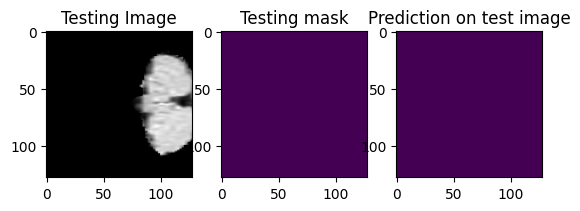

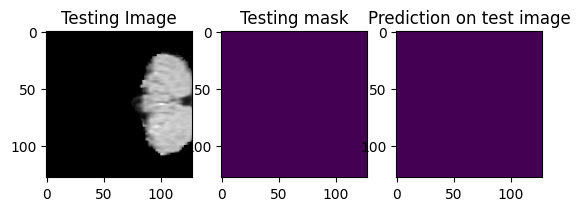

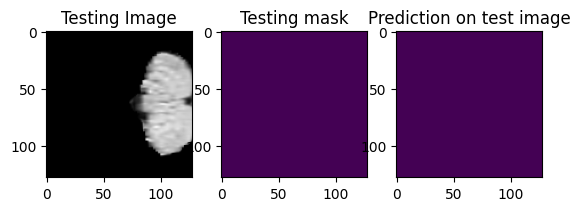

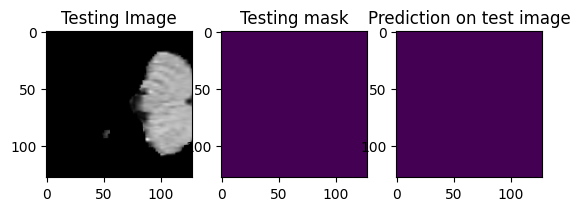

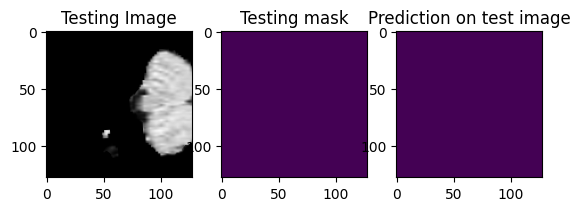

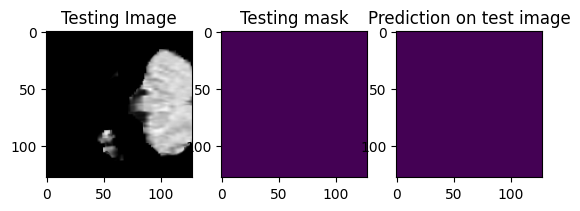

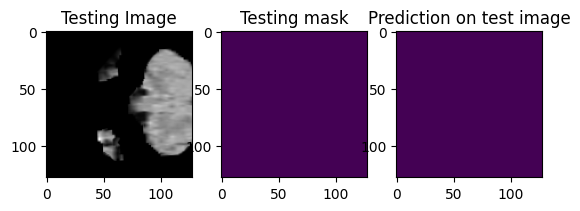

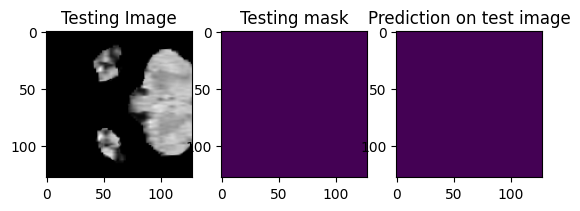

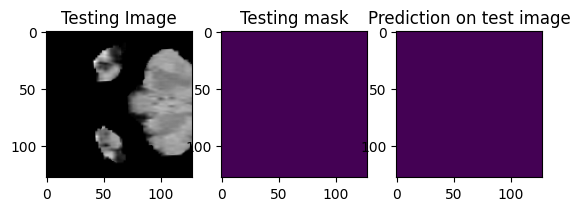

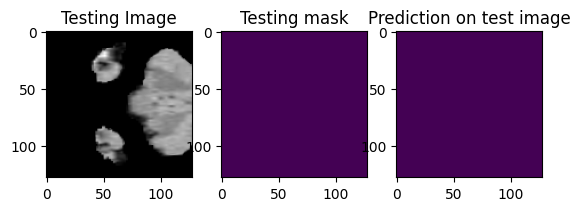

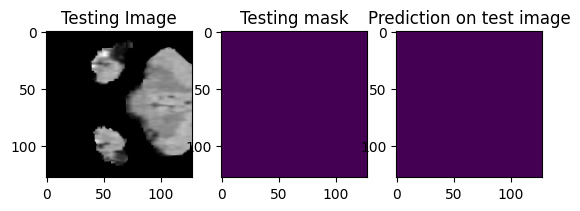

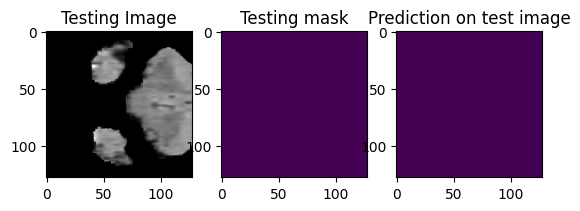

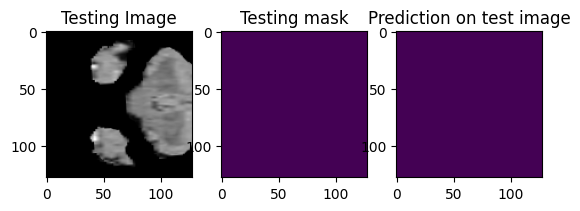

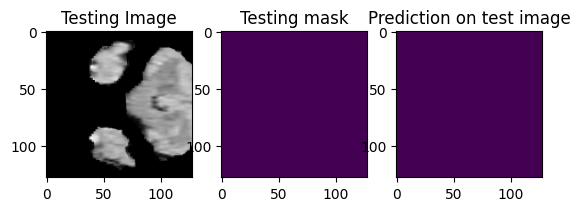

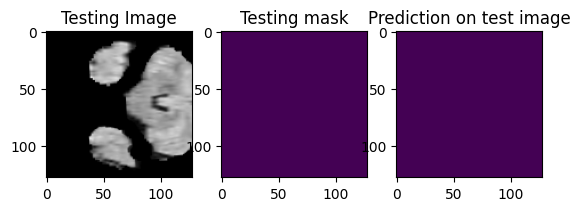

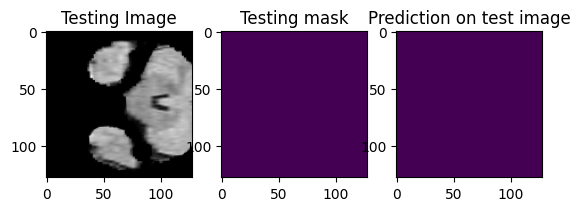

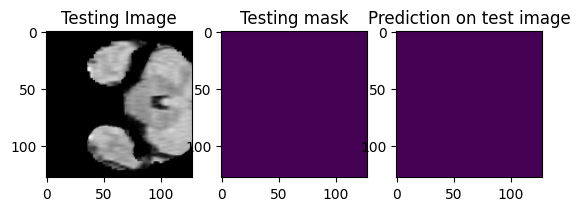

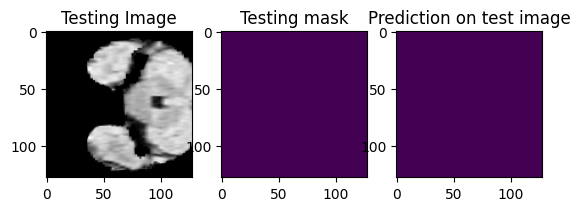

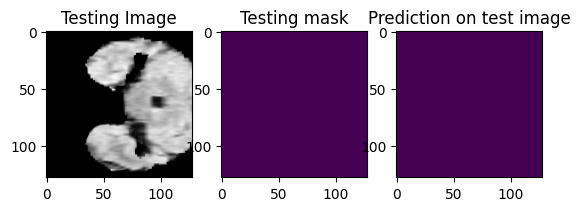

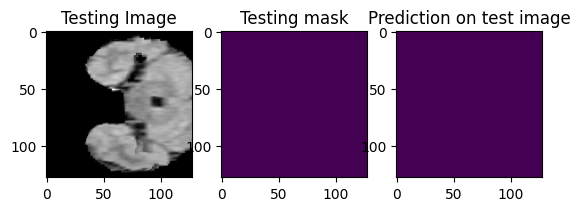

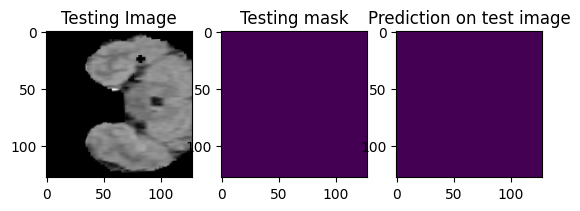

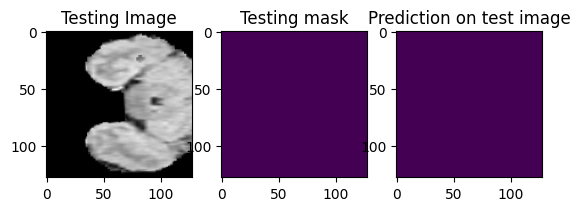

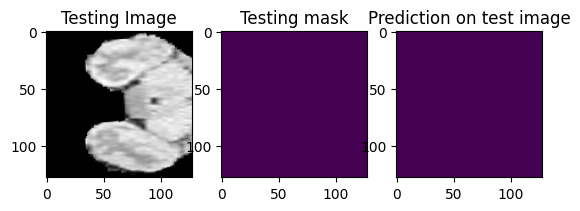

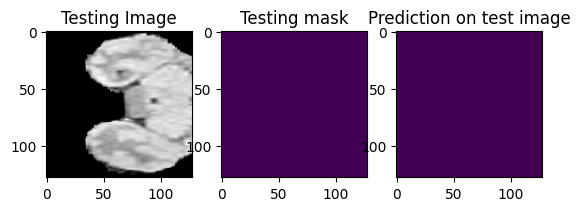

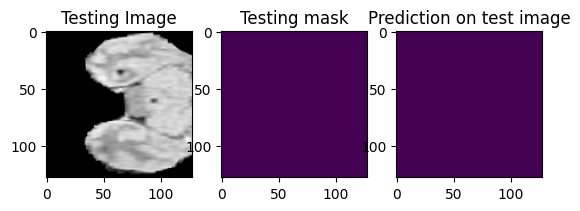

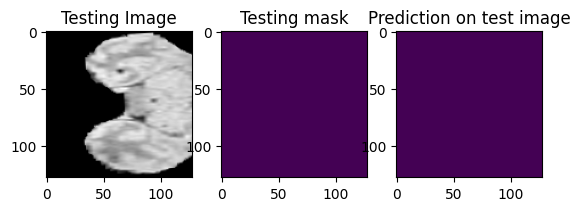

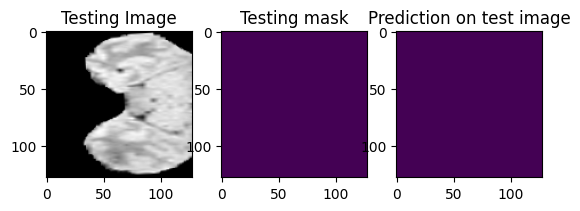

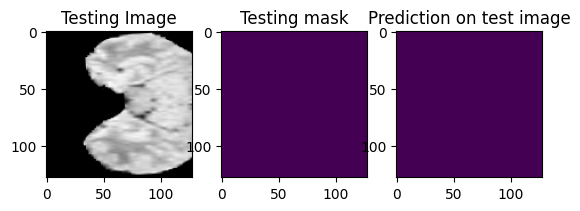

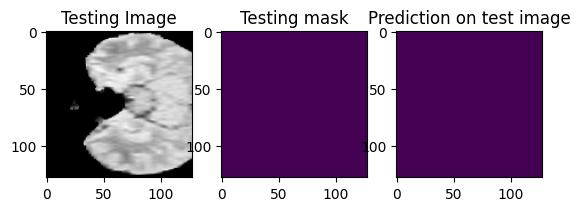

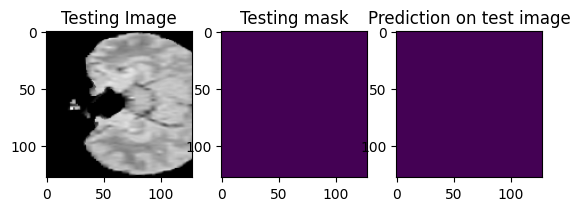

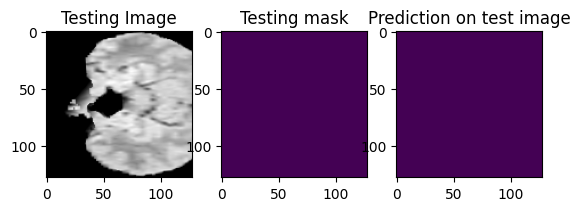

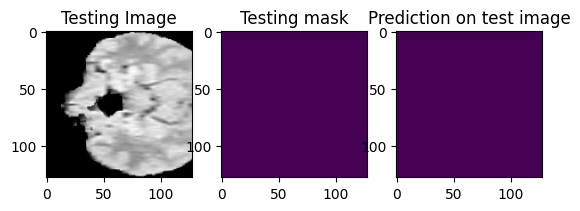

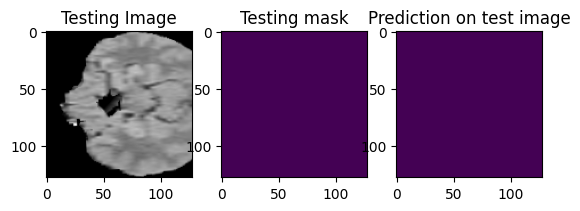

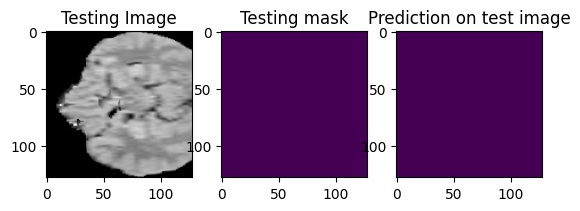

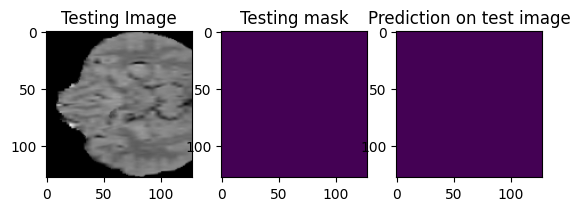

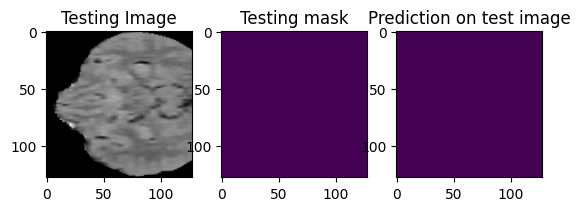

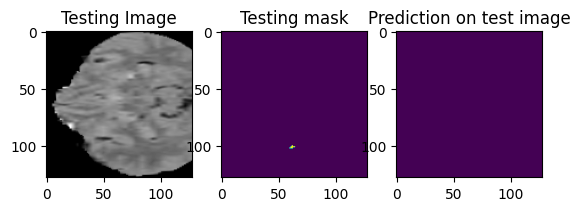

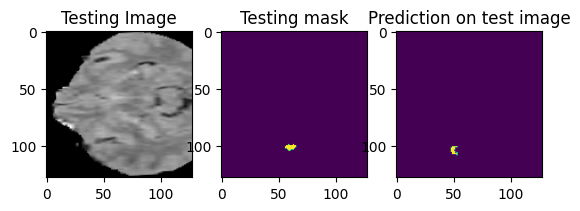

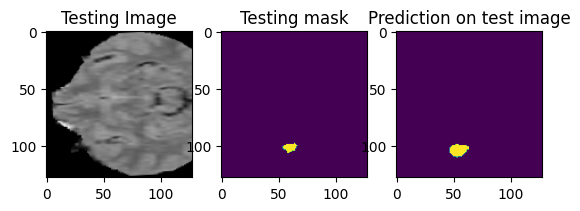

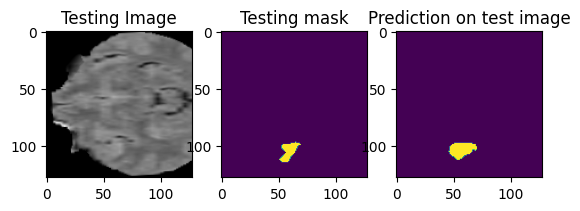

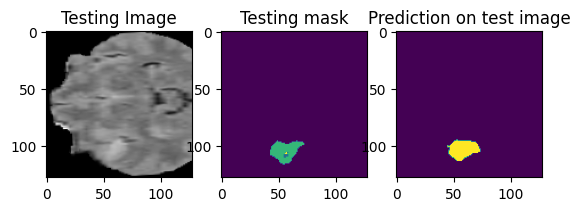

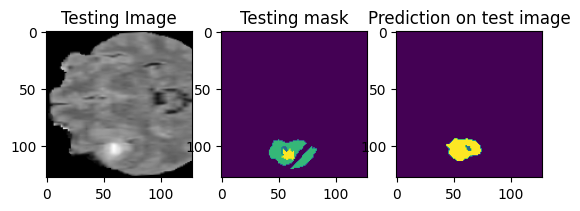

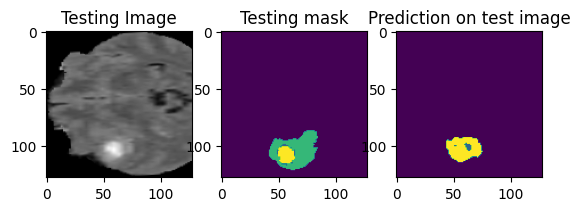

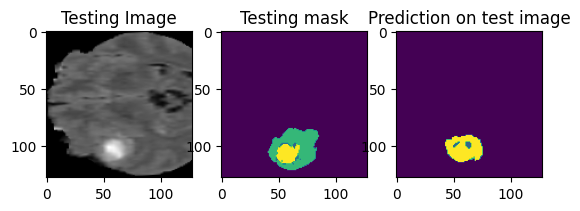

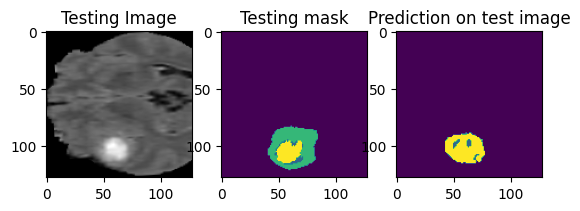

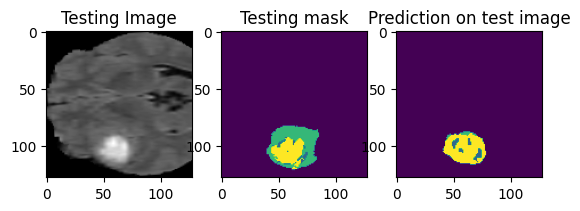

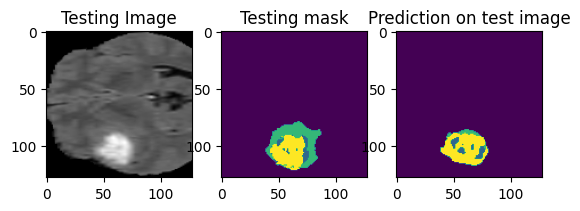

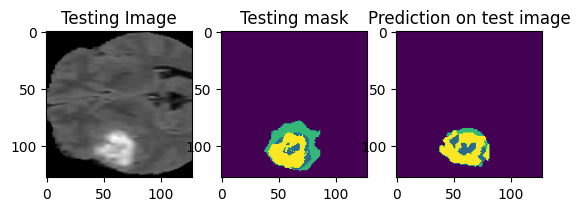

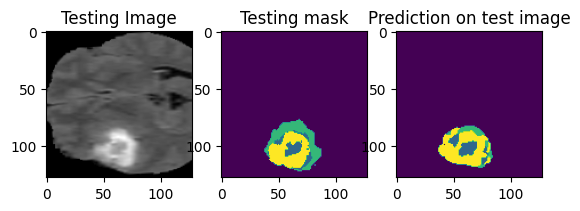

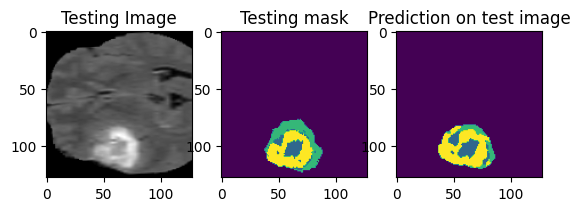

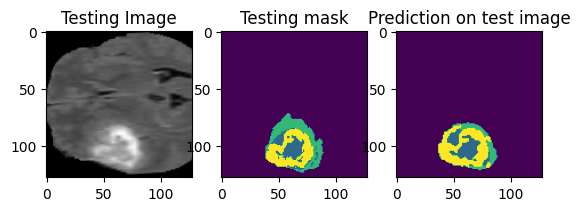

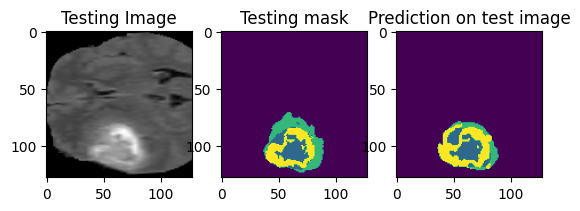

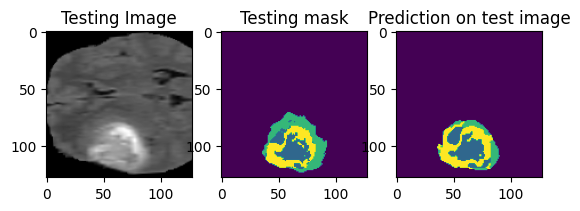

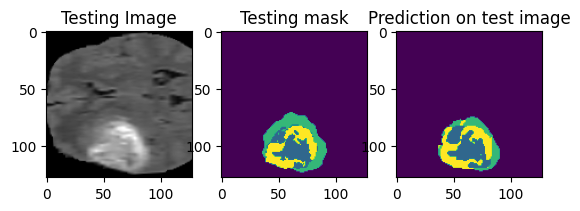

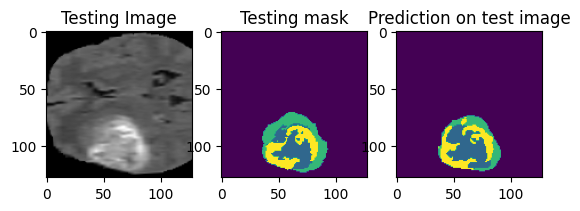

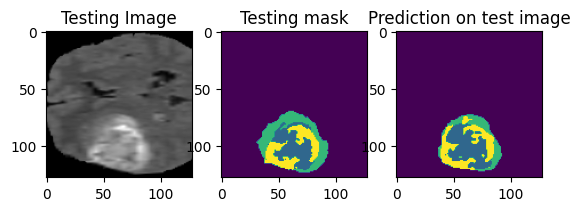

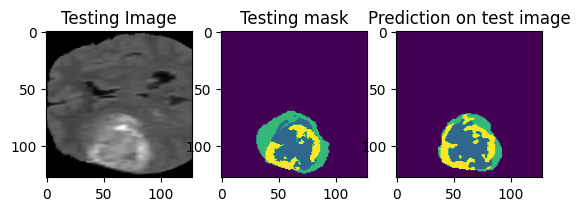

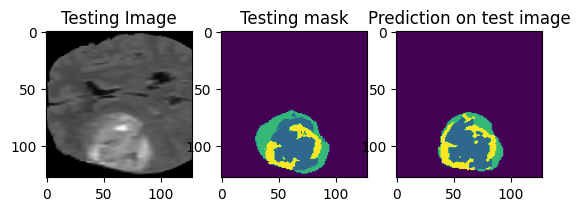

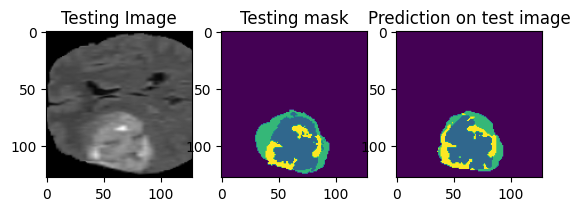

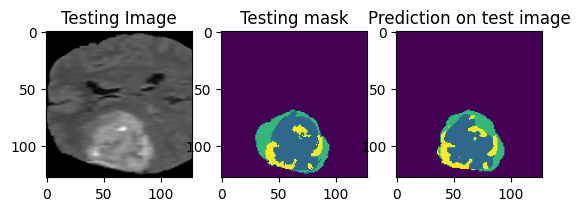

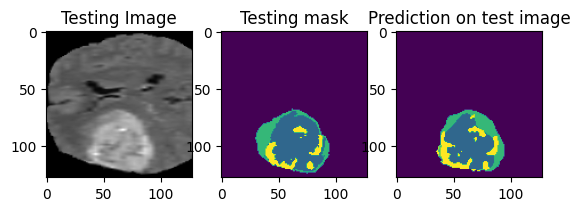

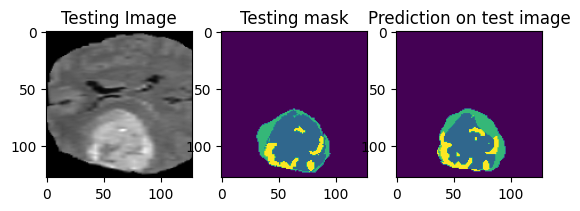

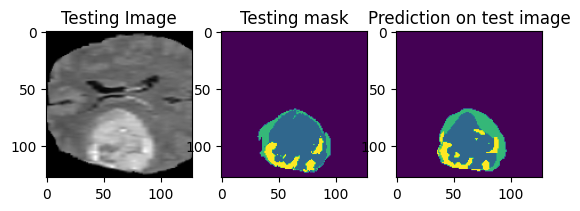

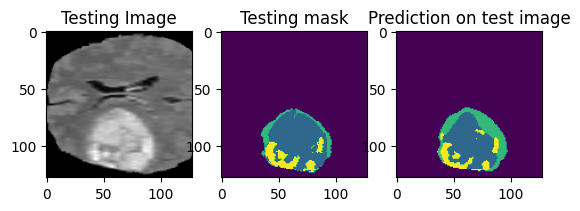

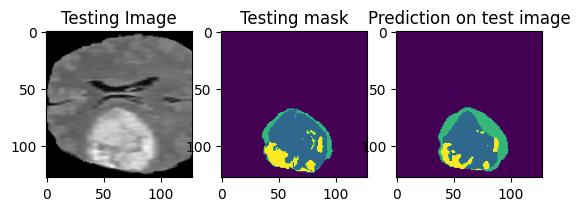

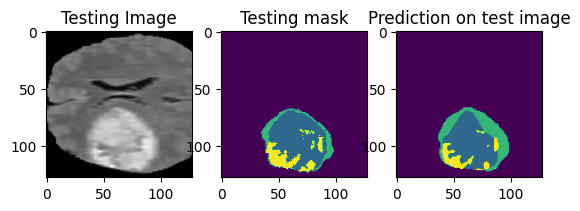

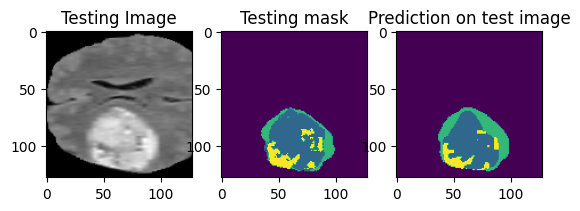

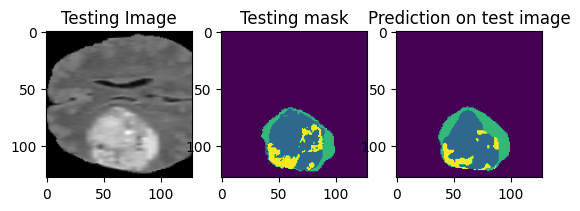

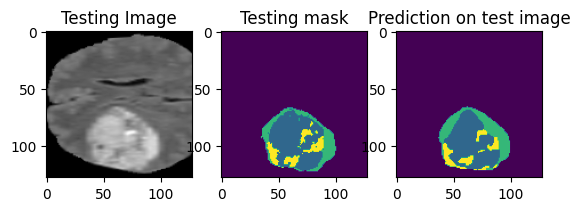

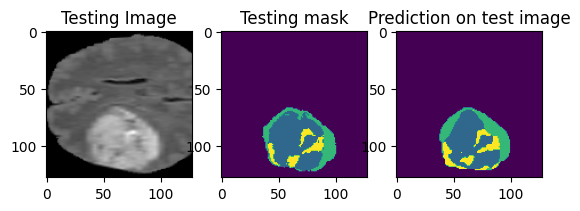

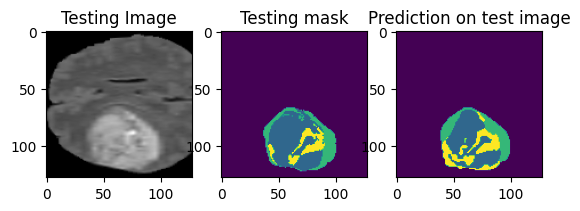

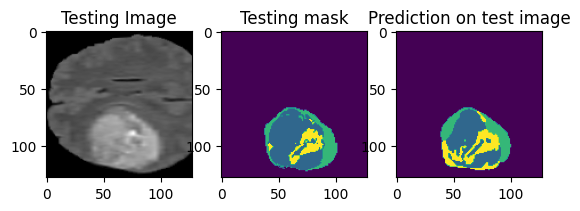

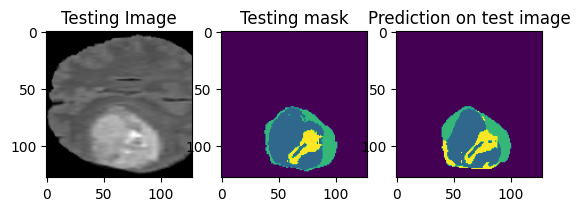

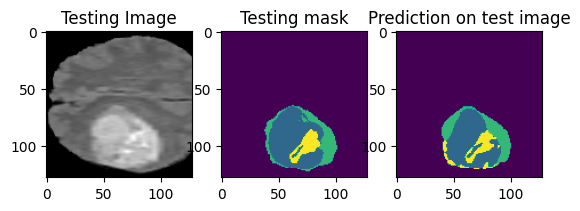

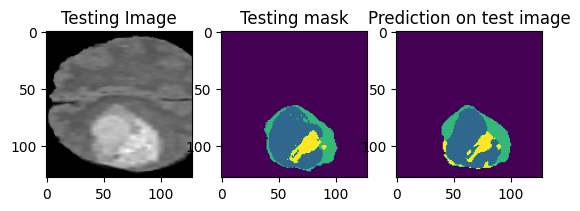

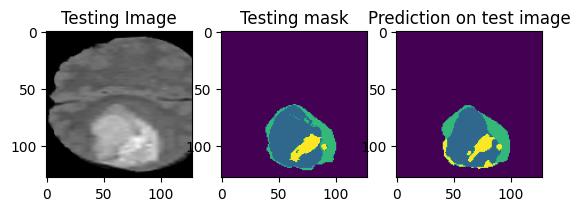

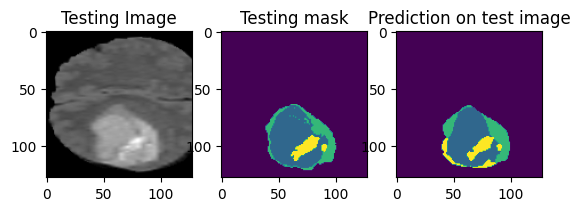

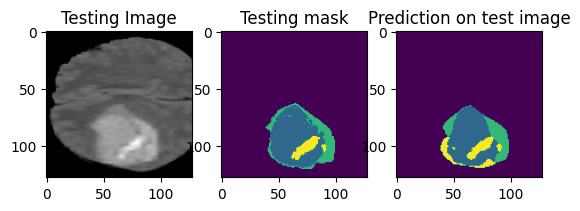

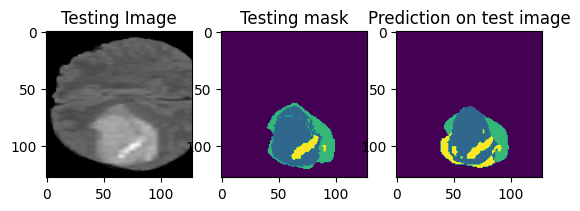

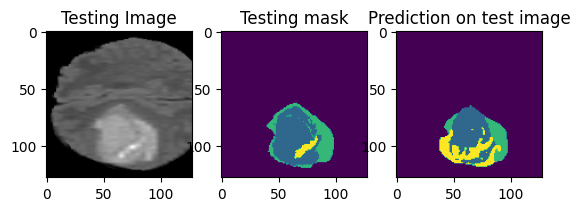

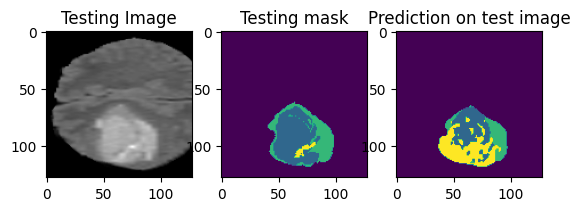

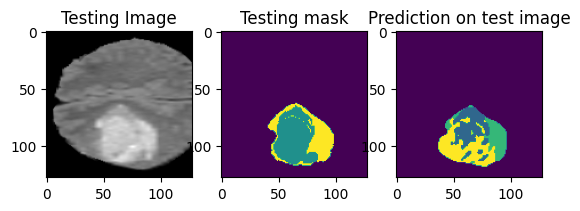

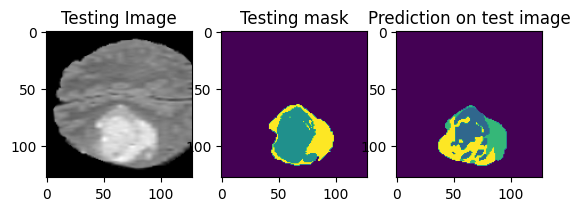

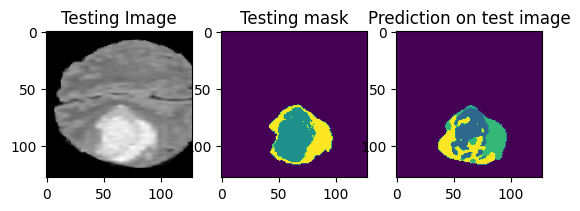

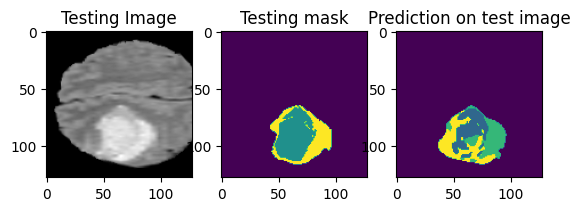

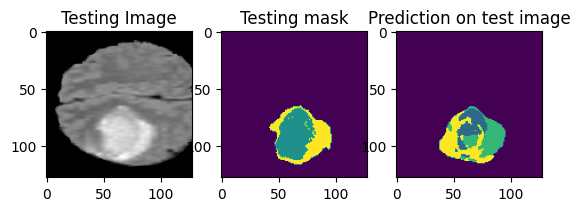

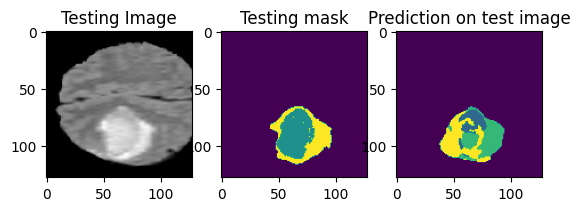

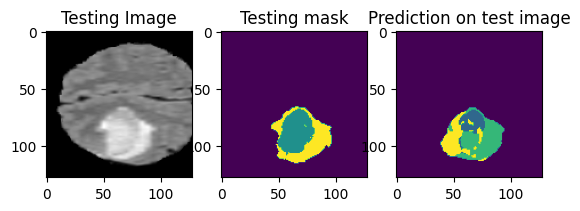

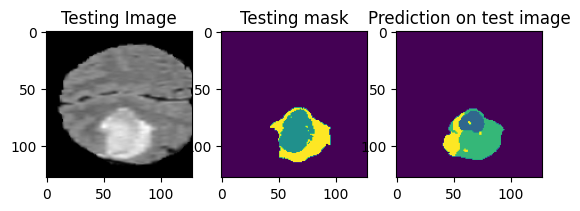

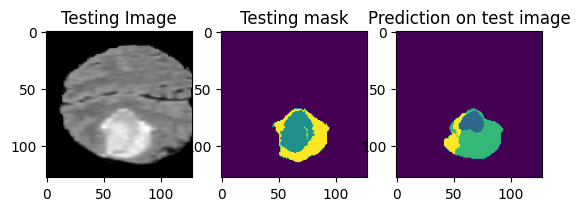

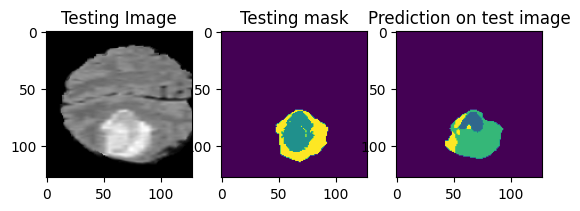

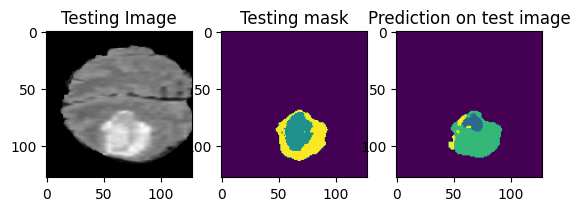

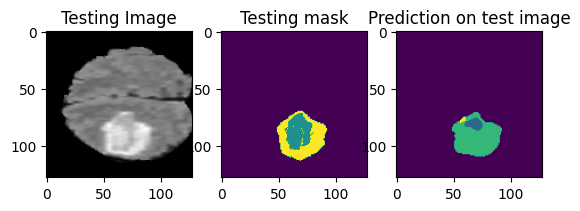

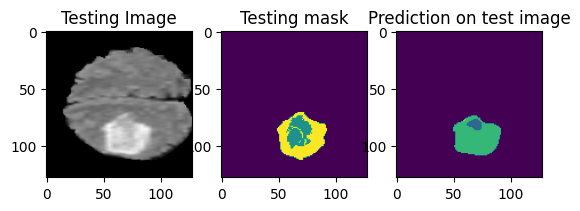

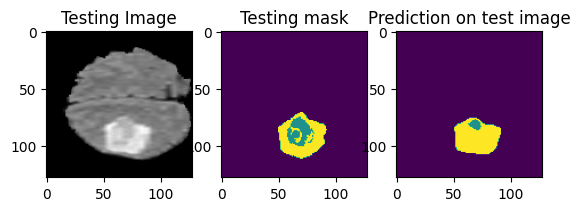

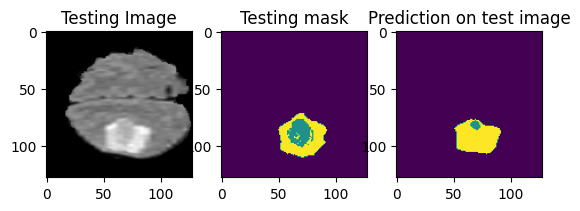

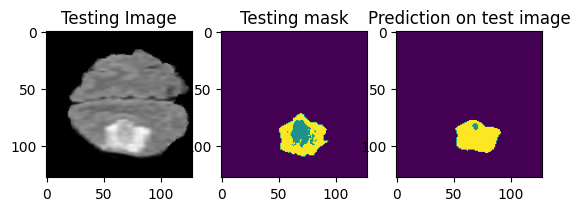

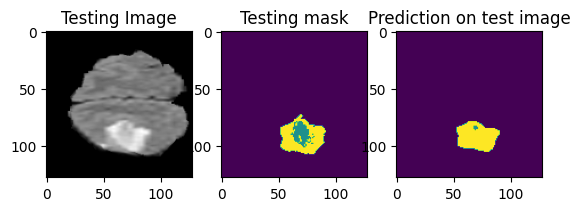

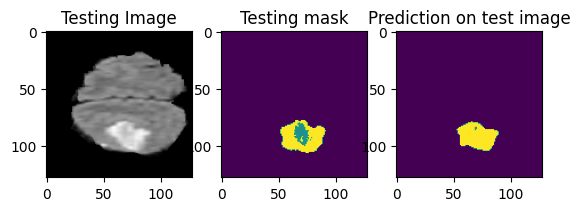

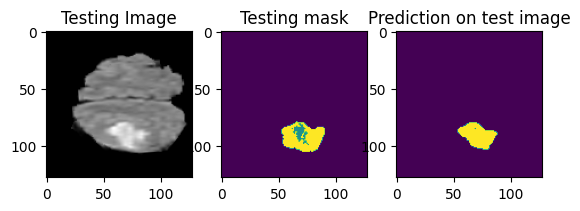

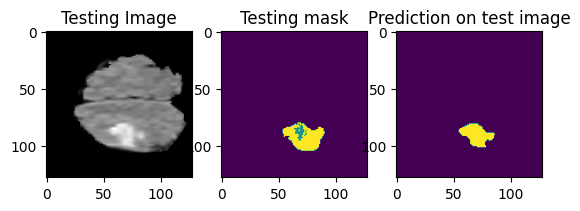

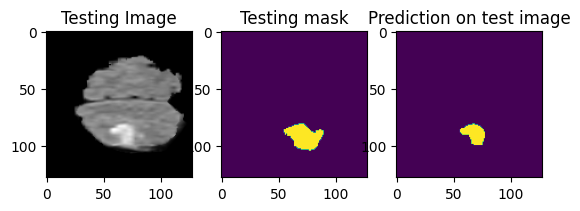

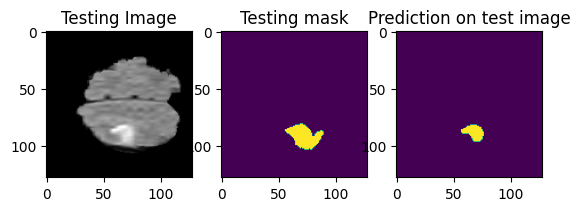

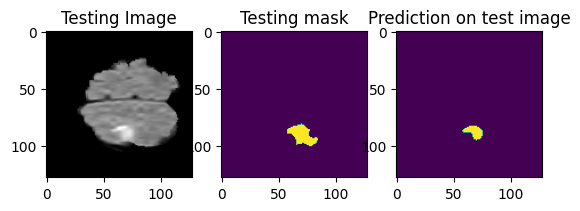

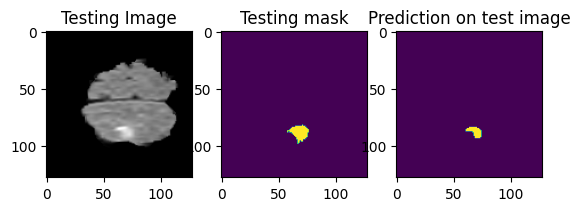

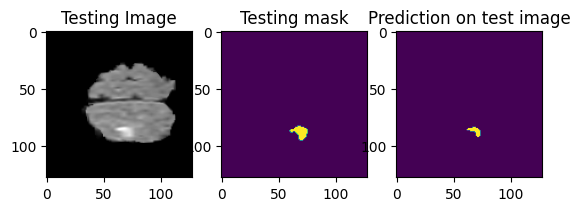

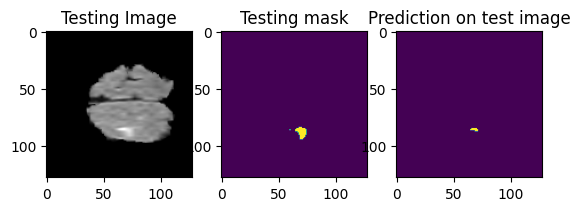

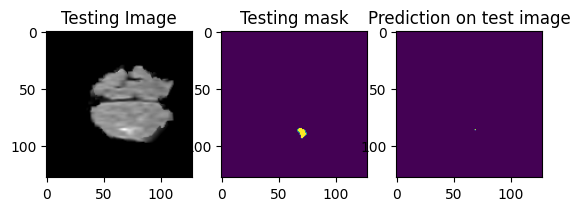

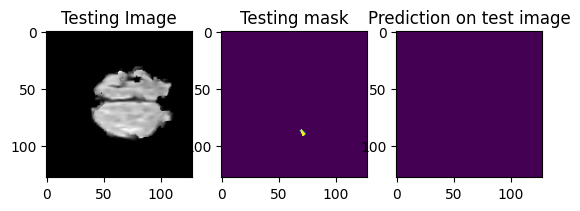

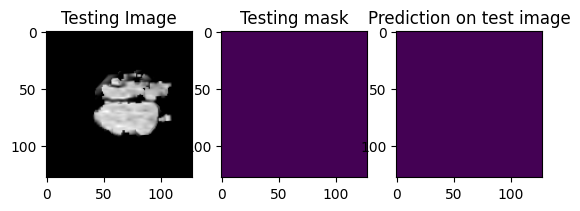

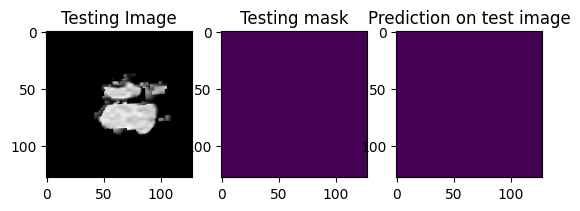

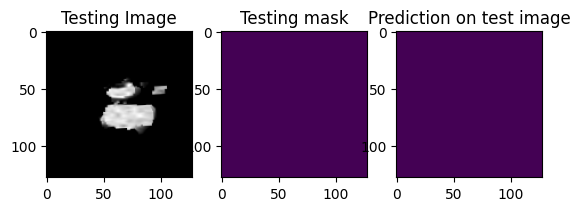

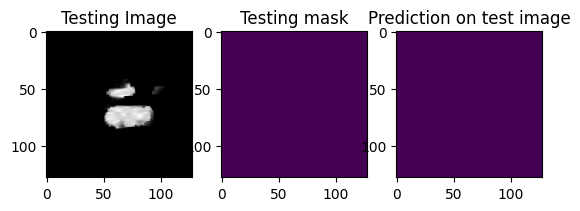

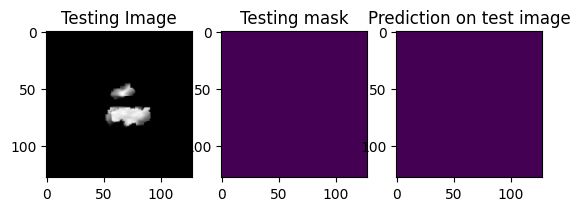

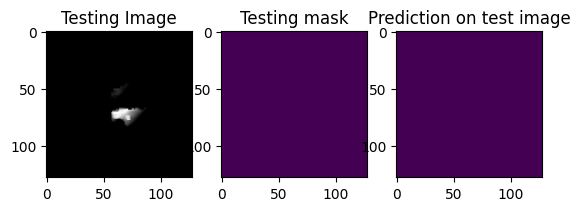

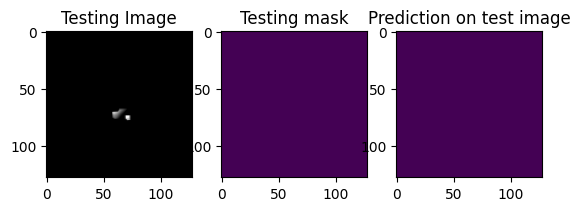

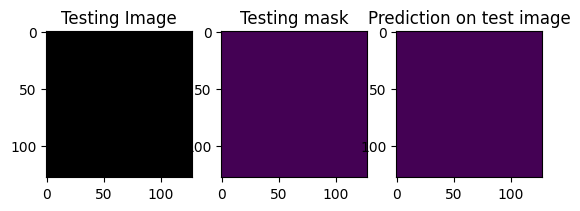

In [20]:
plt.figure(figsize=(12, 8))
n_slices = test_prediction_argmax.shape[2]
plt.figure(figsize=(12, 8))
for i in range(n_slices):
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,i,1], cmap='gray')
    plt.subplot(232)
    plt.title('Testing mask')
    plt.imshow(test_mask_argmax[:,:,i])
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_prediction_argmax[:,:, i])


    plt.show()

In [22]:
from keras.models import load_model
my_model=load_model('unet_100_epochsv2', 
                      compile=False)

In [24]:
batch_size=4 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 6s 6s/step
Mean IoU = 0.6952685
